In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 28.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Paths
base_dir = '/content/drive/My Drive/CV 2'
candidate_gt_path = os.path.join(base_dir, 'Candidate_Set', 'Candidate_Groundtruth.xlsx')
query_gt_path = os.path.join(base_dir, 'Query_Set', 'query_groundtruth.xlsx')
candidate_image_dir = os.path.join(base_dir, 'Candidate_Set', 'Candidate_Images_Selected_500')
query_image_dir = os.path.join(base_dir, 'Query_Set', 'Query_Images')

# New dataset structure
output_dir = '/content/drive/My Drive/CV Final/Dataset_augment_50'
os.makedirs(output_dir, exist_ok=True)
image_train_dir = os.path.join(output_dir, 'images', 'train')
image_val_dir = os.path.join(output_dir, 'images', 'val')
label_train_dir = os.path.join(output_dir, 'labels', 'train')
label_val_dir = os.path.join(output_dir, 'labels', 'val')
for path in [image_train_dir, image_val_dir, label_train_dir, label_val_dir]:
    os.makedirs(path, exist_ok=True)


In [ ]:
candidate_gt = pd.read_excel(candidate_gt_path)
query_gt = pd.read_excel(query_gt_path)


In [ ]:
# Helper Function to Remove White Pixels and Create Accurate Masks
def remove_white_pixels(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    mask = cv2.bitwise_and(img, img, mask=thresh)
    return mask

# Generate Bounding Boxes Based on Masks
def generate_bounding_boxes(mask):
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours]  # (x, y, w, h)
    return boxes

In [ ]:
def map_top_classes(df_list, image_dir, top_n=50):
    class_image_counts = {}

    for filename in os.listdir(image_dir):
        class_id = filename.split('_')[0]
        class_image_counts[class_id] = class_image_counts.get(class_id, 0) + 1

    top_classes = sorted(class_image_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_class_ids = {cls for cls, _ in top_classes}

    class_mapping = {cls: idx for idx, cls in enumerate(sorted(top_class_ids))}

    for df in df_list:
      df['Product ID'] = df['Product ID'].astype(str).str.zfill(7)

      # Apply the mapping to the 'Product ID' column
      df['MappedProductID'] = df['Product ID'].apply(lambda x: class_mapping.get(x, -1))  # Map to -1 if not in top classes
      df = df[df['MappedProductID'] != -1]

    return class_mapping, df



In [ ]:
class_mapping, df1 = map_top_classes([candidate_gt, query_gt], candidate_image_dir, top_n=50)
print("Top 50 Class Mapping:", class_mapping)

Top 50 Class Mapping: {'0000059': 0, '0000133': 1, '0000919': 2, '0022236': 3, '0025619': 4, '0025684': 5, '0025700': 6, '0025833': 7, '0025858': 8, '0025965': 9, '0026062': 10, '0028852': 11, '0039461': 12, '0039487': 13, '0039545': 14, '0357780': 15, '0358515': 16, '0523050': 17, '1030030': 18, '1130475': 19, '1202290': 20, '1237684': 21, '1320605': 22, '1519156': 23, '1795079': 24, '1830363': 25, '1883321': 26, '1883339': 27, '1883545': 28, '1934991': 29, '1942689': 30, '2065670': 31, '2151785': 32, '2196459': 33, '2349637': 34, '2350072': 35, '2393767': 36, '2436681': 37, '2524361': 38, '2524387': 39, '2619351': 40, '2619369': 41, '2619377': 42, '2685410': 43, '2692499': 44, '3013703': 45, '3300779': 46, '3300795': 47, '3300829': 48, '3302965': 49}


In [ ]:
# Data Augmentation Functions
def horizontal_flip(image):
    return cv2.flip(image, 1)

def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (w, h))

def blur_image(image, ksize=5):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def random_crop(image, crop_size=(400, 400)):
    h, w = image.shape[:2]
    crop_h, crop_w = crop_size
    if h < crop_h or w < crop_w:
        return image
    x = np.random.randint(0, w - crop_w + 1)
    y = np.random.randint(0, h - crop_h + 1)
    return image[y:y + crop_h, x:x + crop_w]

def shear_image(image, shear_factor):
    h, w = image.shape[:2]
    M = np.array([[1, shear_factor, 0], [0, 1, 0]], dtype=np.float32)
    return cv2.warpAffine(image, M, (w, h))

def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def adjust_brightness_contrast(image, alpha=1.0, beta=0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def add_gaussian_noise(image, mean=0, std=10):
    noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
    return cv2.add(image, noise)

def coarse_dropout(image, max_holes=5, max_size=50):
    h, w = image.shape[:2]
    for _ in range(max_holes):
        x = np.random.randint(0, w)
        y = np.random.randint(0, h)
        x1 = np.clip(x - max_size // 2, 0, w)
        x2 = np.clip(x + max_size // 2, 0, w)
        y1 = np.clip(y - max_size // 2, 0, h)
        y2 = np.clip(y + max_size // 2, 0, h)
        image[y1:y2, x1:x2] = 0
    return image

# List of augmentations
augmentations = [
    horizontal_flip,
    lambda img: rotate_image(img, angle=30),
    lambda img: blur_image(img, ksize=5),
    lambda img: random_crop(img, crop_size=(400, 400)),
    lambda img: shear_image(img, shear_factor=0.2),
    to_gray,
    lambda img: adjust_brightness_contrast(img, alpha=1.2, beta=30),
    lambda img: add_gaussian_noise(img, mean=0, std=20),
    lambda img: coarse_dropout(img, max_holes=5, max_size=30),
]

In [ ]:
def create_yolo_annotations_with_masks(
    df, image_dir, output_image_dir, output_label_dir, class_mapping, augment=True
):

    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for _, row in df.iterrows():
        product_id = str(row['Product ID']).zfill(7)  # Ensure zero-padding for comparison
        class_id = row['MappedProductID']

        # Skip if class_id is not in the selected top 50
        if class_id not in class_mapping.values():
            continue

        # Get all images for the current product ID
        image_pattern = os.path.join(image_dir, f"{product_id}_*.jpg")
        image_files = glob.glob(image_pattern)
        if not image_files:
            print(f"No images found for Product ID: {product_id}")
            continue

        for img_path in image_files:
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, (640, 640))

            # Remove white pixels and create a mask
            mask = remove_white_pixels(img)

            # Generate bounding boxes from the mask
            boxes = generate_bounding_boxes(mask)

            # Skip if no bounding boxes were generated
            if not boxes:
                continue

            # Save the original image
            image_name = os.path.basename(img_path)
            output_img_path = os.path.join(output_image_dir, image_name)
            cv2.imwrite(output_img_path, img)

            # Create a corresponding YOLO label file
            label_name = os.path.splitext(image_name)[0] + '.txt'
            label_path = os.path.join(output_label_dir, label_name)
            with open(label_path, 'w') as label_file:
                for box in boxes:
                    x, y, w, h = box
                    x_center = (x + w / 2) / 640
                    y_center = (y + h / 2) / 640
                    width = w / 640
                    height = h / 640
                    label_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

            # Apply augmentations
            if augment:
                for i, aug in enumerate(augmentations):
                    try:
                        aug_img = aug(img)  # Apply augmentation
                        aug_img_name = f"{os.path.splitext(image_name)[0]}_aug_{i}.jpg"
                        aug_img_path = os.path.join(output_image_dir, aug_img_name)
                        cv2.imwrite(aug_img_path, aug_img)

                        # Create a corresponding YOLO label file for the augmented image
                        aug_label_name = f"{os.path.splitext(image_name)[0]}_aug_{i}.txt"
                        aug_label_path = os.path.join(output_label_dir, aug_label_name)
                        with open(aug_label_path, 'w') as aug_label_file:
                            for box in boxes:
                                x, y, w, h = box
                                x_center = (x + w / 2) / 640
                                y_center = (y + h / 2) / 640
                                width = w / 640
                                height = h / 640
                                aug_label_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")
                    except Exception as e:
                        print(f"Augmentation failed for {image_name} with error: {e}")

# Process candidate and query datasets
create_yolo_annotations_with_masks(
    candidate_gt, candidate_image_dir, image_train_dir, label_train_dir, class_mapping
)
create_yolo_annotations_with_masks(
    query_gt, query_image_dir, image_val_dir, label_val_dir, class_mapping
)


No images found for Product ID: 0025684
No images found for Product ID: 0025684
No images found for Product ID: 0025684
No images found for Product ID: 0025684
No images found for Product ID: 0025700
No images found for Product ID: 0025700
No images found for Product ID: 0025700
No images found for Product ID: 0025700
No images found for Product ID: 0026062
No images found for Product ID: 0026062
No images found for Product ID: 0026062
No images found for Product ID: 0026062
No images found for Product ID: 0028852
No images found for Product ID: 0028852
No images found for Product ID: 0028852
No images found for Product ID: 0028852
No images found for Product ID: 0039461
No images found for Product ID: 0039461
No images found for Product ID: 0039461
No images found for Product ID: 0039461
No images found for Product ID: 0039487
No images found for Product ID: 0039487
No images found for Product ID: 0039487
No images found for Product ID: 0039487
No images found for Product ID: 0357780


In [ ]:
def filter_images_by_classes(image_dir, label_dir, class_mapping):
    image_files = glob.glob(f"{image_dir}/*.jpg")
    filtered_images = []

    for img_path in image_files:
        image_name = os.path.basename(img_path)
        label_path = os.path.splitext(img_path.replace(image_dir, label_dir))[0] + '.txt'

        # Extract the product ID from the image name
        product_id = image_name.split('_')[0]

        if product_id in class_mapping:
            filtered_images.append((img_path, label_path))

    return filtered_images


def split_and_move_files(filtered_images, image_train_dir, label_train_dir, image_val_dir, label_val_dir):
    train_files, val_files = train_test_split(filtered_images, test_size=0.2, random_state=42)

    # Move validation images and labels to the validation folder
    for img_path, label_path in val_files:
        # Move image
        val_file_name = os.path.basename(img_path)
        dest_image_path = os.path.join(image_val_dir, val_file_name)

        if os.path.exists(dest_image_path):
            base_name, ext = os.path.splitext(val_file_name)
            dest_image_path = os.path.join(image_val_dir, f"{base_name}_conflict{ext}")

        shutil.move(img_path, dest_image_path)

        # Move corresponding label file
        label_file_name = os.path.basename(label_path)
        dest_label_path = os.path.join(label_val_dir, label_file_name)

        if os.path.exists(dest_label_path):
            base_name, ext = os.path.splitext(label_file_name)
            dest_label_path = os.path.join(label_val_dir, f"{base_name}_conflict{ext}")

        shutil.move(label_path, dest_label_path)

    # Move training images and labels to the training folder
    for img_path, label_path in train_files:
        # Move image
        train_file_name = os.path.basename(img_path)
        dest_image_path = os.path.join(image_train_dir, train_file_name)

        if os.path.exists(dest_image_path):
            base_name, ext = os.path.splitext(train_file_name)
            dest_image_path = os.path.join(image_train_dir, f"{base_name}_conflict{ext}")

        shutil.move(img_path, dest_image_path)

        # Move corresponding label file
        label_file_name = os.path.basename(label_path)
        dest_label_path = os.path.join(label_train_dir, label_file_name)

        if os.path.exists(dest_label_path):
            base_name, ext = os.path.splitext(label_file_name)
            dest_label_path = os.path.join(label_train_dir, f"{base_name}_conflict{ext}")

        shutil.move(label_path, dest_label_path)


filtered_images = filter_images_by_classes(image_train_dir, label_train_dir, class_mapping)

split_and_move_files(filtered_images, image_train_dir, label_train_dir, image_val_dir, label_val_dir)


In [ ]:
import yaml

# Convert class_mapping to ensure keys and values are strings
class_mapping_str = {str(k): str(v) for k, v in class_mapping.items()}
yolo_data_config_path = os.path.join(base_dir, 'yolo_data_config.yaml')

data_config = {
    'train': image_train_dir,
    'val': image_val_dir,
    'nc': len(class_mapping_str),
    'names': list(class_mapping_str.keys())
}

# YAML File
with open(yolo_data_config_path, 'w') as file:
    yaml.dump(data_config, file, default_flow_style=False)


In [ ]:
model1 = YOLO('yolov8n.pt')

# Training
model1.train(
    data=yolo_data_config_path,
    epochs=50,
    imgsz=256,
    batch=8,
    cache=False,
    save_dir='/content/runs/detect/train4',
)

print("Training completed! Check results in:", '/content/runs/detect/train4')


100%|██████████| 6.25M/6.25M [00:00<00:00, 77.3MB/s]


Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/My Drive/CV 2/yolo_data_config.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=50

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 92.4MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/My Drive/CV Final/Dataset_augment_50/labels/train... 1760 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1760/1760 [00:18<00:00, 96.74it/s] 


train: New cache created: /content/drive/My Drive/CV Final/Dataset_augment_50/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/My Drive/CV Final/Dataset_augment_50/labels/val... 440 images, 0 backgrounds, 0 corrupt: 100%|██████████| 440/440 [00:06<00:00, 70.52it/s] 


val: New cache created: /content/drive/My Drive/CV Final/Dataset_augment_50/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000185, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.321G     0.9104      4.446      1.212         23        256: 100%|██████████| 220/220 [00:38<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:05<00:00,  4.85it/s]

                   all        440       3441     0.0251      0.264     0.0282     0.0252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.285G     0.8059      4.045      1.152         23        256: 100%|██████████| 220/220 [00:35<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:05<00:00,  4.81it/s]


                   all        440       3441     0.0271      0.408     0.0635     0.0538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.287G     0.8309      3.684      1.166         22        256: 100%|██████████| 220/220 [00:33<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]

                   all        440       3441      0.431      0.158      0.108     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.287G     0.8414      3.299      1.182         17        256: 100%|██████████| 220/220 [00:35<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.20it/s]

                   all        440       3441      0.212      0.291      0.176      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.287G     0.8733      2.978      1.201         20        256: 100%|██████████| 220/220 [00:36<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:58<00:00,  2.07s/it]


                   all        440       3441      0.347      0.303      0.229      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.287G     0.8204      2.699      1.172         15        256: 100%|██████████| 220/220 [00:34<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.34it/s]


                   all        440       3441      0.284      0.323      0.238      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.287G     0.8018      2.525      1.161         24        256: 100%|██████████| 220/220 [00:33<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:05<00:00,  4.86it/s]

                   all        440       3441      0.343      0.344      0.287      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.287G     0.7776      2.364      1.146         27        256: 100%|██████████| 220/220 [00:31<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.06it/s]

                   all        440       3441      0.406      0.369      0.334      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.287G     0.7656      2.194      1.139         25        256: 100%|██████████| 220/220 [00:31<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.47it/s]


                   all        440       3441      0.476      0.413      0.363      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.287G     0.7449      2.041      1.134         19        256: 100%|██████████| 220/220 [00:33<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.04it/s]


                   all        440       3441      0.584      0.415      0.386      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.287G     0.7223      1.962      1.121         26        256: 100%|██████████| 220/220 [00:34<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.55it/s]

                   all        440       3441       0.58      0.402      0.398       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.285G     0.7077      1.878      1.118         18        256: 100%|██████████| 220/220 [00:34<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.86it/s]

                   all        440       3441      0.662      0.414      0.416      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.287G     0.6886      1.807      1.095         20        256: 100%|██████████| 220/220 [00:34<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.87it/s]

                   all        440       3441      0.632      0.446      0.421       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.287G     0.6617      1.712      1.087         20        256: 100%|██████████| 220/220 [00:33<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


                   all        440       3441      0.624      0.445      0.425      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.287G     0.6652       1.64      1.085         24        256: 100%|██████████| 220/220 [00:32<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]

                   all        440       3441      0.642      0.452      0.423      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.287G     0.6637      1.594      1.083         19        256: 100%|██████████| 220/220 [00:31<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.82it/s]

                   all        440       3441       0.63      0.457      0.432      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.287G     0.6451      1.544      1.069         19        256: 100%|██████████| 220/220 [00:37<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  5.92it/s]


                   all        440       3441      0.676      0.461      0.446      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.287G     0.6413      1.495      1.084         23        256: 100%|██████████| 220/220 [00:33<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.86it/s]


                   all        440       3441      0.723      0.458      0.451      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.285G     0.6003      1.442      1.053         20        256: 100%|██████████| 220/220 [00:35<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.70it/s]


                   all        440       3441      0.743      0.446       0.45      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.287G     0.6208      1.398      1.058         25        256: 100%|██████████| 220/220 [00:33<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.83it/s]

                   all        440       3441      0.688      0.484      0.451        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.287G      0.612      1.386       1.06         15        256: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.58it/s]

                   all        440       3441      0.733      0.453      0.467      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.287G     0.6155      1.356      1.057         19        256: 100%|██████████| 220/220 [00:34<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  5.87it/s]

                   all        440       3441      0.758      0.456      0.473      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.287G      0.611      1.329      1.056         23        256: 100%|██████████| 220/220 [00:40<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.11it/s]


                   all        440       3441      0.754      0.476      0.468      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.287G     0.5974      1.297      1.055         53        256: 100%|██████████| 220/220 [00:31<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.18it/s]

                   all        440       3441      0.789      0.468      0.475      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.287G     0.5969      1.248      1.045         25        256: 100%|██████████| 220/220 [00:35<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.52it/s]

                   all        440       3441      0.793      0.468      0.483      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.287G     0.5837      1.246      1.042         19        256: 100%|██████████| 220/220 [00:34<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.94it/s]


                   all        440       3441      0.777      0.462      0.472      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.285G     0.5598       1.23      1.036         14        256: 100%|██████████| 220/220 [00:49<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.09it/s]


                   all        440       3441       0.82      0.468      0.487      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.287G     0.5634      1.217      1.032         24        256: 100%|██████████| 220/220 [00:34<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:05<00:00,  5.08it/s]

                   all        440       3441      0.836      0.465      0.492      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.285G     0.5674      1.188      1.036         26        256: 100%|██████████| 220/220 [00:32<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.98it/s]

                   all        440       3441      0.823      0.464      0.491      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.285G     0.5563      1.173      1.037         22        256: 100%|██████████| 220/220 [00:31<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.57it/s]


                   all        440       3441      0.807      0.461      0.492      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.285G     0.5589      1.128      1.031         22        256: 100%|██████████| 220/220 [00:33<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.75it/s]

                   all        440       3441      0.817       0.47      0.492      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.285G     0.5419       1.11      1.021         22        256: 100%|██████████| 220/220 [00:33<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.81it/s]


                   all        440       3441      0.844      0.468      0.496      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.285G      0.559      1.123      1.022         28        256: 100%|██████████| 220/220 [00:33<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.77it/s]

                   all        440       3441      0.818      0.473      0.494      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.285G     0.5463      1.097       1.03         17        256: 100%|██████████| 220/220 [00:34<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  5.63it/s]

                   all        440       3441      0.828       0.48      0.497      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.285G     0.5445      1.073      1.036         19        256: 100%|██████████| 220/220 [00:31<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


                   all        440       3441      0.881      0.466      0.501      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.285G      0.533      1.054      1.022         33        256: 100%|██████████| 220/220 [00:31<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  5.78it/s]


                   all        440       3441      0.852      0.473      0.503      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.287G     0.5213      1.033      1.017         25        256: 100%|██████████| 220/220 [00:33<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.77it/s]

                   all        440       3441      0.864      0.473      0.501      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.285G     0.5289      1.053      1.015         24        256: 100%|██████████| 220/220 [00:33<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.92it/s]


                   all        440       3441      0.864      0.464      0.501      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.285G     0.5332      1.022      1.018         17        256: 100%|██████████| 220/220 [00:33<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.06it/s]

                   all        440       3441      0.853      0.471      0.504       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.285G     0.5309      1.018      1.015         23        256: 100%|██████████| 220/220 [00:32<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.29it/s]

                   all        440       3441       0.82      0.481      0.505      0.462


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.285G     0.5032      0.944      1.018          8        256: 100%|██████████| 220/220 [00:31<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]


                   all        440       3441      0.847      0.478      0.503      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.285G     0.4805     0.8782      1.005          8        256: 100%|██████████| 220/220 [00:32<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.41it/s]


                   all        440       3441      0.827       0.48      0.504      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.285G     0.4681      0.827      1.009          8        256: 100%|██████████| 220/220 [00:33<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.75it/s]

                   all        440       3441      0.843      0.468      0.503      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.285G     0.4529     0.8278      0.995         13        256: 100%|██████████| 220/220 [00:33<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.84it/s]


                   all        440       3441      0.856      0.474      0.505      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.285G      0.455     0.8153     0.9943          9        256: 100%|██████████| 220/220 [00:33<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.89it/s]

                   all        440       3441      0.899      0.464      0.504      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.285G     0.4286     0.7496     0.9764         13        256: 100%|██████████| 220/220 [00:33<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.06it/s]


                   all        440       3441      0.858       0.48      0.505      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.287G     0.4364     0.7603     0.9802          8        256: 100%|██████████| 220/220 [00:31<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


                   all        440       3441      0.835      0.487      0.506      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.287G      0.434     0.7641     0.9813         10        256: 100%|██████████| 220/220 [00:31<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:06<00:00,  4.10it/s]

                   all        440       3441      0.836       0.49      0.507      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.285G     0.4331     0.7501     0.9762         14        256: 100%|██████████| 220/220 [00:31<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:05<00:00,  5.31it/s]


                   all        440       3441       0.87      0.475      0.507      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.285G     0.4274     0.7637     0.9688          8        256: 100%|██████████| 220/220 [00:32<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.77it/s]


                   all        440       3441      0.852       0.48      0.507      0.468

50 epochs completed in 0.575 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,015,398 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.11it/s]


                   all        440       3441      0.852       0.48      0.507      0.468
               0000059          3          3      0.499          1      0.995      0.995
               0000133         14         21          1      0.561      0.676      0.638
               0000919          7          7      0.934          1      0.995      0.975
               0022236          7         42      0.959      0.167      0.174      0.147
               0025619         15        591      0.571      0.022     0.0474     0.0372
               0025684         11         33      0.485      0.333       0.29      0.259
               0025700         13         17      0.827      0.706      0.755      0.749
               0025833          9         81      0.907      0.111      0.123        0.1
               0025858         10         52      0.959      0.192      0.217      0.193
               0025965         12         20      0.904        0.6       0.61      0.569
               002606

In [ ]:
# trained model (best.pt)
m = YOLO('/content/drive/My Drive/CV 2/best-50.pt')
metrics = m.val()


NameError: name 'YOLO' is not defined

In [ ]:
#CONFUSION MATRIX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from ultralytics import YOLO

# Load the trained model (best.pt)
model = YOLO('/content/drive/My Drive/CV Final/best-50.pt')

# Run validation to get the results and predictions
metrics = model.val()

# Extract true labels (targets) and predicted labels (pred)
targets = metrics['targets']  # Ground truth labels
preds = metrics['pred']  # Predicted labels

# Convert to numpy arrays (if necessary)
# Each row in targets and preds corresponds to an image and its class label.
# Assuming targets are in the format: [image_idx, class_idx, x1, y1, x2, y2]
# And preds are in the format: [image_idx, class_idx, x1, y1, x2, y2, confidence_score]

# Flatten targets and predictions to get the class indexes for confusion matrix
true_labels = targets[:, 1].astype(int)  # Extract true class labels
predicted_labels = preds[:, 0].astype(int)  # Extract predicted class labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using Seaborn heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.names, yticklabels=model.names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
#plots
import matplotlib.pyplot as plt

# Assuming the metrics object contains the following
# Adjust according to the actual structure of the metrics dictionary
epochs = range(1, len(metrics['maps'][0]) + 1)  # Number of epochs (assuming 'maps' is a list)

# Extract mAP at IoU=50 (mAP@50) and mAP@50-95
mAP_50 = [map_value[0] for map_value in metrics['maps']]  # mAP@50 for each epoch
mAP_50_95 = [map_value[1] for map_value in metrics['maps']]  # mAP@50-95 for each epoch

# Extract precision and recall (if available)
precision = metrics['precision']  # This might vary based on the model version
recall = metrics['recall']

# Plot mAP vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, mAP_50, label="mAP@50", color='g', linestyle='-', marker='o')
plt.plot(epochs, mAP_50_95, label="mAP@50-95", color='orange', linestyle='-', marker='x')
plt.title("mAP vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot precision and recall
if precision and recall:
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, precision, label="Precision", color='purple', linestyle='-', marker='o')
    plt.plot(epochs, recall, label="Recall", color='brown', linestyle='--', marker='x')
    plt.title("Precision and Recall vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Precision / Recall")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
print("\nValidation Metrics:")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Mean Precision: {metrics.box.mp:.4f}")
print(f"Mean Recall: {metrics.box.mr:.4f}")


Validation Metrics:
mAP@0.5: 0.5343
mAP@0.5:0.95: 0.4913
Mean Precision: 0.8632
Mean Recall: 0.5112


In [ ]:
import os
import cv2
from ultralytics import YOLO

# Define the path to the test directory and trained YOLO model
test_image_dir = '/content/drive/My Drive/CV Final/Dataset_augment_50/Test/images'
output_dir = '/content/drive/My Drive/CV Final/Dataset_augment_50/Test/labels'
model_path = '/content/drive/My Drive/CV Final/best-50.pt'


model_test = YOLO(model_path)
print(class_mapping)

test_images = sorted(os.listdir(test_image_dir))[:10]
for image_name in test_images:
    image_path = os.path.join(test_image_dir, image_name)

    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_name}")
        continue

    results = model_test.predict(source=image_path, save=True, save_txt=True, project=output_dir, name='test_results')

    print(f"\nResults for {image_name}:")
    for result in results:
        boxes = result.boxes.xyxy
        confidences = result.boxes.conf
        class_ids = result.boxes.cls

        for box, confidence, class_id in zip(boxes, confidences, class_ids):
            print(f"Class ID: {int(class_id)}, Confidence: {confidence:.4f}, BBox: {box.tolist()}")

    output_img_path = os.path.join(output_dir, 'test_results', image_name)
    print(f"Processed {image_name}. Saved results to {output_img_path}")

print(f"Test completed for 10 images. Results saved in: {output_dir}")


{'0000059': 0, '0000133': 1, '0000919': 2, '0022236': 3, '0025619': 4, '0025684': 5, '0025700': 6, '0025833': 7, '0025858': 8, '0025965': 9, '0026062': 10, '0028852': 11, '0039461': 12, '0039487': 13, '0039545': 14, '0357780': 15, '0358515': 16, '0523050': 17, '0984765': 18, '1030030': 19, '1130475': 20, '1202290': 21, '1237684': 22, '1320605': 23, '1519156': 24, '1795079': 25, '1830363': 26, '1883321': 27, '1883339': 28, '1883545': 29, '1934991': 30, '1942689': 31, '2065670': 32, '2151785': 33, '2196459': 34, '2349637': 35, '2350072': 36, '2393767': 37, '2436681': 38, '2524361': 39, '2524387': 40, '2619351': 41, '2619369': 42, '2619377': 43, '2685410': 44, '3013703': 45, '3300779': 46, '3300795': 47, '3300829': 48, '3302965': 49}
Could not read image: 0000059_test.jpg

image 1/1 /content/drive/My Drive/CV Final/Dataset_augment_50/Test/images/0000113_test.jpg: 256x256 1 0000059, 1 0000133, 48.8ms
Speed: 1.1ms preprocess, 48.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256

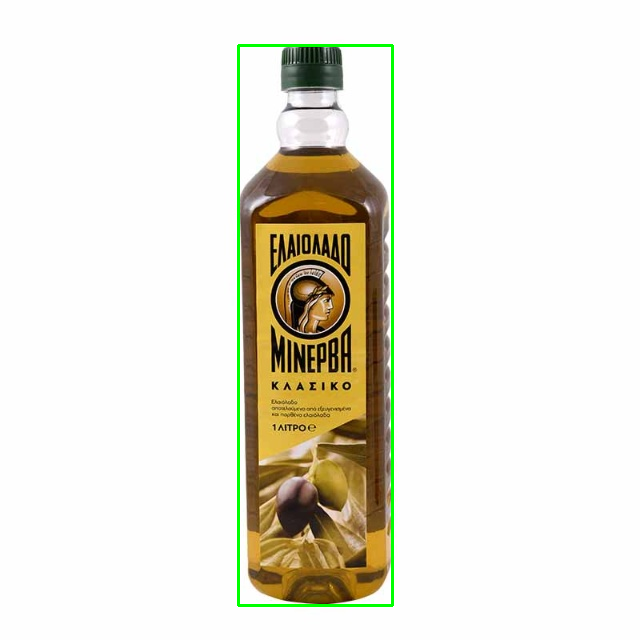

In [ ]:
from google.colab.patches import cv2_imshow
def display_image_with_bboxes(image_path, label_path):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return

    # Get image dimensions
    img_height, img_width = img.shape[:2]

    # Check if label file exists
    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        return

    # Read the label file
    with open(label_path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            # Parse the YOLO format (class_id, x_center, y_center, width, height)
            class_id, x_center, y_center, width, height = map(float, parts)
            class_id = int(class_id)

            # Denormalize bounding box coordinates
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            # Convert center-based coordinates to top-left coordinates
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            # Draw the bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box

    # Display the image with bounding boxes
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
image_path = "/content/drive/My Drive/CV Final/Dataset_augment_50/images/train/0000059_1_conflict.jpg"  # Replace with your image path
label_path = "/content/drive/My Drive/CV Final/Dataset_augment_50/labels/train/0000059_1_conflict.txt"  # Replace with the corresponding label file

display_image_with_bboxes(image_path, label_path)
